In [131]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


# Data Cleanup

## Climate Clean

In [2]:
climate_data = pd.read_parquet("data/climate_data_from_1982.parquet")
climate_data["time"] =   pd.to_datetime(climate_data["time"])
climate_data["year"] = climate_data["year"].astype(int)
climate_data['metric'] = climate_data['metric'].astype('category')
climate_data['code_dep'] = climate_data['code_dep'].astype(str).str.zfill(2)

In [3]:
temps = [
    "near_surface_air_temperature",
    "daily_maximum_near_surface_air_temperature"
]

mask = climate_data["metric"].isin(temps)
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"] - 273.15
mask = climate_data["metric"] == "precipitation"
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"] * 1000  # to mm
climate_data.loc[mask, "value"] = climate_data.loc[mask, "value"].mask(
    climate_data.loc[mask, "value"] < 0.001, 
    0
)
bad_temp = climate_data[
    (climate_data["metric"].isin(temps)) &
    ((climate_data["value"] < -50) | (climate_data["value"] > 60))
]

print("Extreme temp values found:", len(bad_temp))
climate_data.loc[bad_temp.index, "value"] = None
bad_p = climate_data[
    (climate_data["metric"] == "precipitation") &
    (climate_data["value"] > 500)  # >500 mm/day is impossible in France
]

print("Extreme rain values found:", len(bad_p))
climate_data.loc[bad_p.index, "value"] = None

Extreme temp values found: 0
Extreme rain values found: 0


In [4]:
hist_data = climate_data[climate_data["scenario"] == "historical"]
future_data = climate_data[climate_data["scenario"] != "historical"]

In [5]:
hist_data.head()

,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,3.142273
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,1.942413
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,3.268524
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,5.743378
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,5.737213


## Barley Cleanup

In [6]:
barley_data = pd.read_csv("data/barley_yield_from_1982.csv", delimiter=";", index_col=0).reset_index()
dep_map = (
    climate_data[["nom_dep", "code_dep"]]
    .drop_duplicates()
    .set_index("nom_dep")["code_dep"]
    .to_dict()
)

barley_data["code_dep"] = barley_data["department"].map(dep_map)
barley_data["year"] = barley_data["year"].astype(int)

# Compute yield if missing but we have area & production
mask = barley_data["yield"].isna() & barley_data["production"].notna() & barley_data["area"].notna()

barley_data.loc[mask, "yield"] = barley_data.loc[mask, "production"] / barley_data.loc[mask, "area"]

barley_data = barley_data[~(barley_data["yield"].isna())]

# If production is missing but yield and area exist → compute it
mask_prod = barley_data["production"].isna() & barley_data["yield"].notna() & barley_data["area"].notna()
barley_data.loc[mask_prod, "production"] = barley_data.loc[mask_prod, "yield"] * barley_data.loc[mask_prod, "area"]
barley_data.drop(columns="index", inplace=True);

In [7]:
barley_data.head()

,department,year,yield,area,production,code_dep
0,Ain,1982,3.950080,16065.0,63458.0,01
1,Ain,1983,2.648276,14500.0,38400.0,01
2,Ain,1984,4.822580,15500.0,74750.0,01
3,Ain,1985,4.196770,15500.0,65050.0,01
4,Ain,1986,3.598450,12900.0,46420.0,01


# Expositional Analysis

In [8]:
import pandas as pd

# Only temperature
temp = climate_data[climate_data["metric"]=="near_surface_air_temperature"].copy()

# Ensure correct types
temp["value"] = pd.to_numeric(temp["value"], errors="coerce")
temp = temp.replace([np.inf, -np.inf], np.nan).dropna(subset=["value"])
temp["year"] = temp["year"].astype(int)
temp["date"] = temp["time"].dt.date

# Daily mean per department
temp_daily = temp.groupby(["scenario","date","code_dep"])["value"].mean().reset_index()

# Yearly mean per department
temp_year_dep = (
    temp_daily.assign(year=lambda x: pd.to_datetime(x["date"]).dt.year)
              .groupby(["scenario","year","code_dep"])["value"]
              .mean()
              .reset_index()
)

# National annual temperature
temp_year_nat = (
    temp_year_dep.groupby(["scenario","year"])["value"]
                 .mean()
                 .reset_index()
                 .rename(columns={"value":"mean_temp_C"})
)


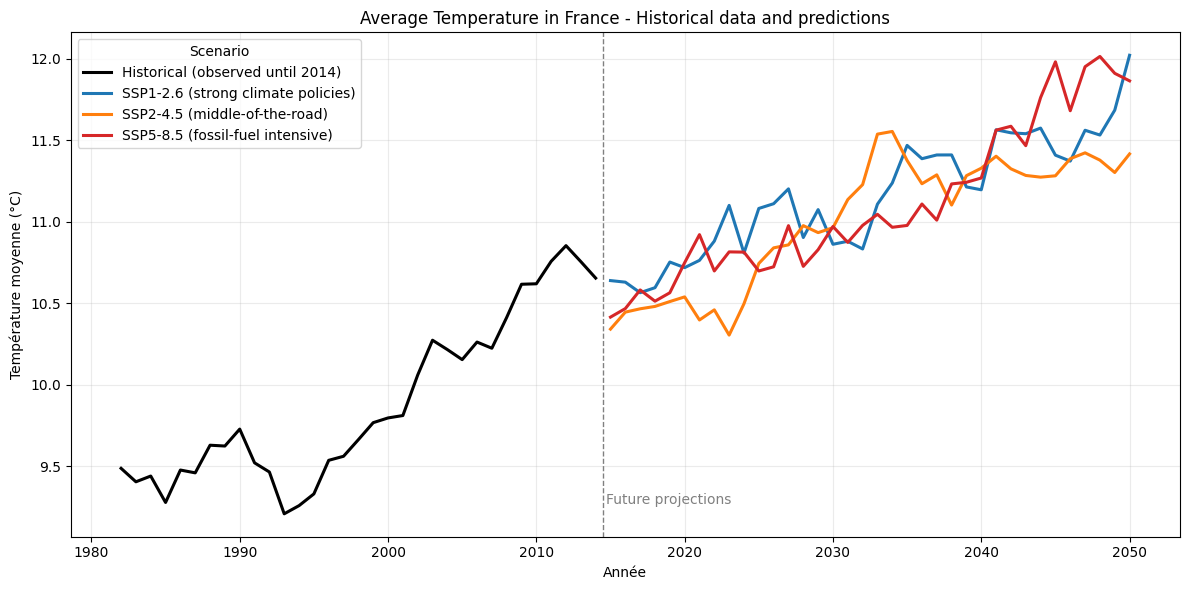

In [9]:
import matplotlib.pyplot as plt

scenarios = {
    "historical": "black",
    "ssp1_2_6": "#1f77b4",
    "ssp2_4_5": "#ff7f0e",
    "ssp5_8_5": "#d62728"
}
legend_labels = {
    "historical": "Historical (observed until 2014)",
    "ssp1_2_6": "SSP1-2.6 (strong climate policies)",
    "ssp2_4_5": "SSP2-4.5 (middle-of-the-road)",
    "ssp5_8_5": "SSP5-8.5 (fossil-fuel intensive)"
}


plt.figure(figsize=(12,6))

for scen, color in scenarios.items():
    df = temp_year_nat[temp_year_nat["scenario"] == scen].copy()
    df["smooth"] = df["mean_temp_C"].rolling(window=5, min_periods=1, center=True).mean()
    plt.plot(df["year"], df["smooth"], label=legend_labels[scen], linewidth=2.2, color=color)

# historical/projection separator
plt.axvline(2014.5, color="grey", linestyle="--", linewidth=1)
plt.text(2014.7, plt.ylim()[0]+0.2, "Future projections", color="grey")

plt.title("Average Temperature in France - Historical data and predictions")
plt.xlabel("Année")
plt.ylabel("Température moyenne (°C)")
plt.grid(alpha=0.25)
plt.legend(title="Scenario")
plt.tight_layout()

In [10]:
import pandas as pd

df = barley_data.copy()

def growth_period(df, start, end):
    d0 = df[df["year"] == start][["code_dep", "yield"]].rename(columns={"yield": "y0"})
    d1 = df[df["year"] == end][["code_dep", "yield"]].rename(columns={"yield": "y1"})
    out = d0.merge(d1, on="code_dep", how="inner")
    out["growth_%"] = (out["y1"] - out["y0"]) / out["y0"] * 100
    return out[["code_dep", "growth_%"]]

growth_80_00  = growth_period(df, 1982, 2000)
growth_02_14  = growth_period(df, 2000, 2014)

growth_80_00 = growth_80_00.rename(columns={"growth_%": "growth_1980_2000"})
growth_02_14 = growth_02_14.rename(columns={"growth_%": "growth_2002_2014"})

growth_all = growth_80_00.merge(growth_02_14, on="code_dep", how="outer")


In [11]:
import geopandas as gpd

url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_FRA_2.json"
france = gpd.read_file(url)
france["code_dep"] = france["CC_2"].str[-2:]

geo = france.merge(growth_all, on="code_dep", how="left")


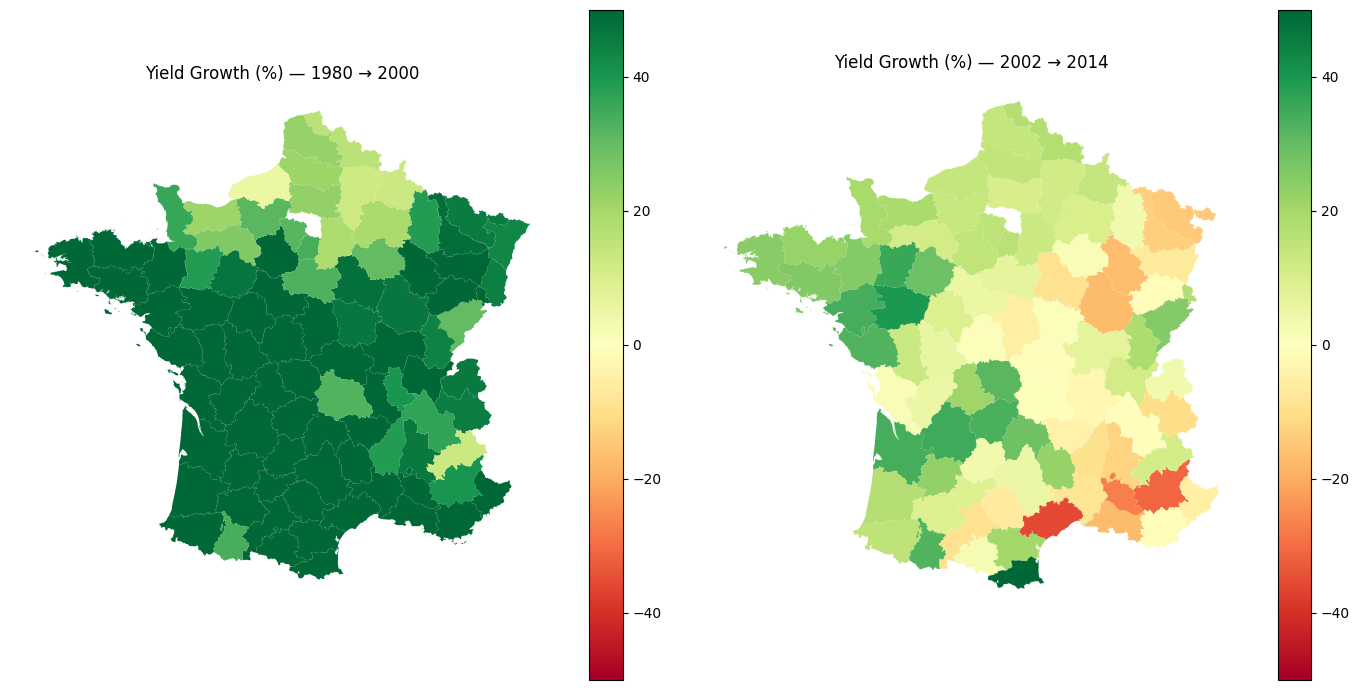

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

geo.plot(column="growth_1980_2000", cmap="RdYlGn", legend=True, ax=axes[0], vmin=-50, vmax=50)
axes[0].set_title("Yield Growth (%) — 1980 → 2000")
axes[0].axis("off")

geo.plot(column="growth_2002_2014", cmap="RdYlGn", legend=True, ax=axes[1], vmin=-50, vmax=50)
axes[1].set_title("Yield Growth (%) — 2002 → 2014")
axes[1].axis("off")

plt.tight_layout()


In [13]:
hist_data[hist_data["metric"]=="precipitation"]

,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,precipitation,0.032987
29951,historical,Ain,01,1982-01-02 12:00:00,1982,precipitation,0.139467
29952,historical,Ain,01,1982-01-03 12:00:00,1982,precipitation,0.090612
29953,historical,Ain,01,1982-01-04 12:00:00,1982,precipitation,0.056591
29954,historical,Ain,01,1982-01-05 12:00:00,1982,precipitation,0.257024
...,...,...,...,...,...,...,...
3738262,historical,Yvelines,78,2014-12-27 12:00:00,2014,precipitation,0.017905
3738263,historical,Yvelines,78,2014-12-28 12:00:00,2014,precipitation,0.004039
3738264,historical,Yvelines,78,2014-12-29 12:00:00,2014,precipitation,0.008867
3738265,historical,Yvelines,78,2014-12-30 12:00:00,2014,precipitation,0.006571


# Climate Indicators

In [ ]:
def build_features(df):
    df = df.copy()
    df["month"] = df["time"].dt.month
    
    def assign_season(m):
        if m in [10, 11, 12, 1, 2, 3]:
            return "winter"
        elif m in [4, 5, 6]:
            return "spring"
        else:
            return "summer"
    
    df["season"] = df["month"].apply(assign_season)

    # Split metrics
    T = df[df.metric == "near_surface_air_temperature"].copy()
    Tmax = df[df.metric == "daily_maximum_near_surface_air_temperature"].copy()
    P = df[df.metric == "precipitation"].copy()

    # Thermal features
    T["GDD"] = np.maximum(T["value"], 0)
    T["Frost"] = (T["value"] < 0).astype(int)

    temp_agg = T.groupby(["code_dep", "year", "season"]).agg({
        "GDD": "sum",
        "Frost": "sum",
        "value": "var"
    }).rename(columns={"value": "TempVar"}).reset_index()

    # Heat stress
    Tmax["HeatStress"] = np.maximum(Tmax["value"] - 30, 0)
    max_agg = Tmax.groupby(["code_dep", "year", "season"]).agg({
        "HeatStress": "sum"
    }).reset_index()

    # Rain features
    P["Dry"] = (P["value"] == 0).astype(int)
    P["HeavyRain"] = (P["value"] > 20).astype(int)
    prec_agg = P.groupby(["code_dep", "year", "season"]).agg({
        "value": "sum",
        "Dry": "sum",
        "HeavyRain": "sum"
    }).rename(columns={"value": "Prec"}).reset_index()

    # Merge + pivot
    feat = temp_agg.merge(max_agg, on=["code_dep", "year", "season"], how="outer")
    feat = feat.merge(prec_agg, on=["code_dep", "year", "season"], how="outer")

    features = feat.pivot_table(index=["code_dep", "year"], columns="season").reset_index()
    features.columns = ['_'.join(col).strip('_') for col in features.columns.values]

    # Composite climate indicators
    features["WTI_spring"] = features["HeatStress_spring"] / (features["Prec_spring"] + 1e-6)
    features["EGDD_spring"] = features["GDD_spring"] * (features["Prec_spring"] / (features["Prec_spring"] + 60))
    
    return features


In [110]:
history_features = build_features(hist_data)

In [19]:
future_good = future_data[future_data["scenario"] == "ssp1_2_6"]
future_medium = future_data[future_data["scenario"] == "ssp2_4_5"]
future_bad = future_data[future_data["scenario"] == "ssp5_8_5"]

In [ ]:
future_good = build_features(future_good)
future_medium =  build_features(future_medium)
future_bad = build_features(future_bad)

In [118]:
scenario_data_map = {
    "ssp1_2_6": future_good,
    "ssp2_4_5": future_medium,
    "ssp5_8_5": future_bad
}
future_all = (
    pd.concat(scenario_data_map, axis=0, keys=scenario_data_map.keys(),
              names=["scenario", "row"])
    .reset_index(level="row", drop=True)
    .reset_index()
)


In [123]:
train_df = history_features.merge(barley_data, on=["code_dep","year"])
X = train_df.drop(columns=["yield","department","area","production"])  # keep code_dep, year
y = train_df["yield"]


In [ ]:
model = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

model.fit(X,y)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler()), ('ridge', Ridge())])

In [132]:
# Extract trained Ridge
ridge_est = model.named_steps["ridge"]

# Columns the model saw:
feat_cols = X.columns

# Scale coefficients visualization
weights = pd.Series(ridge_est.coef_, index=feat_cols).sort_values(key=lambda x: abs(x), ascending=False)

In [ ]:
X_future = future_all.drop(columns=["scenario"])
if "BCPI" in X_future.columns:
    X_future = X_future.drop(columns=["BCPI"])

future_all["BCPI"] = model.predict(X_future)
future_results = future_all[["scenario","code_dep","year","BCPI"]]